# Symbolic regression on regular expressions

by **G**ene **E**xpression **P**rogramming (GEP)

Matherials from [geppy documentation](https://geppy.readthedocs.io/en/latest/intro_GEP.html)

## Useful theory

### Symbolic regression
```
Symbolic regression is a type of regression analysis that searches the space of mathematical expressions to find the model that best fits a given dataset, both in terms of accuracy and simplicity.
```

### Gene expression programming (GEP)
```
Gene expression programming (GEP) belongs to the family of evolutionary algorithms and is closely related to genetic algorithms and genetic programming (GP). Like GP, GEP is a special field of evolutionary computation that aims at building programs automatically to solve problems independently of their domain, i.e., the search space of GEP consists of computer problems and mathematical models.
```

### Functions and terminals

```
Just following the terminology of GP, there are two kinds of primitives in GEP: function and terminal. A function is a primitive that can accepts one or more arguments and returns a result after evaluation, while a terminal represents a constant or a variable in a given program.
```

## Intro to GEP
For example:

Functions alphabet: [max, +, *]

Terminals alphabet: (x, y, 3, 4)

- gene <max,+,+,*,x,x,x,y,3,4,y>
- gene = head <max,+,+,*> + tail <x,x,x,y,3,4,y>

**Genotype**: 

max++*xxxy34y

**Phenotype** (Expression Tree):
```
[max]
    [+]
        (x)
        (x)
    [+]
        (x)
    [*]
        (y)
        (3)
```

**ORF (K-expression)**

[max, +, +, *, x, x, x, y, 3]

```
It is easy to notice that the last two elements in the gene don’t appear in the expression tree. Although in GEP the start site is always the first position of a gene, the termination point does not always coincide with the last position of a gene. It is common for GEP genes to have non-coding regions downstream of the termination point. In such a sense, the decoding of genes (or chromosomes) into expression trees is similar to gene expression in nature. The coding region of a gene is called open reading frames (ORFs), which is also named K-expression in GEP.

As stated previously, GEP chromosomes have fixed length and are composed of one or more genes of equal length. Therefore the length of a gene is also fixed. Thus, in GEP, what varies is not the length of genes (which is constant), but the length of the ORFs. Indeed, the length of an ORF may be equal to or less than the length of the gene. Due to the possible existence of non-coding regions in GEP genes, a gene of a fixed length can encode a variety of expression trees, i.e., computer programs or mathematical expressions. 
```

- h - length of head
- t - length of tail
- n - maximum of arity of the function with the most arguments

$t=h(n-1)+1$

# Examples of GEP

In [1]:
#!pip3 install geppy
#!pip3 install graphviz

### 1. Boolean function identification problem

#### 1.1 Synthetic dataset

In [2]:
def f(a, b, c, d):
    """ The true model, which only involves three inputs on purpose."""
    return (a and d) or not c

In [3]:
import itertools

# generate the training set which contains all the 16 samples
X = []
Y = []
for a, b, c, d in itertools.product([True, False], repeat=4):
    X.append((a, b, c, d))
    Y.append(f(a, b, c, d))

#### 1.2 Creating the primitives set

In [4]:
import geppy as gep
import operator

# terminals
pset = gep.PrimitiveSet('Main', input_names=['a', 'b', 'c', 'd'])

# functions
pset.add_function(operator.and_, 2)
pset.add_function(operator.or_, 2)
pset.add_function(operator.not_, 1)

#### 1.3 Create the individual and population

In [5]:
from deap import creator, base, tools

creator.create("FitnessMax", base.Fitness, weights=(1,))  # to maximize the objective (fitness)
creator.create("Individual", gep.Chromosome, fitness=creator.FitnessMax)

In [6]:
h = 5   # head length
n_genes = 2   # number of genes in a chromosome
toolbox = gep.Toolbox()
toolbox.register('gene_gen', gep.Gene, pset=pset, head_length=h)
toolbox.register('individual', creator.Individual, gene_gen=toolbox.gene_gen, n_genes=n_genes, linker=operator.or_)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# compile utility: which translates an individual into an executable function (Lambda)
toolbox.register('compile', gep.compile_, pset=pset)

#### 1.4 Define the fitness evaluation function

In [7]:
def evaluate(individual):
    """Evalute the fitness of an individual"""
    func = toolbox.compile(individual)  # a lambda function
    n_correct = 0
    for (a, b, c, d), y in zip(X, Y):
        prediction = func(a, b, c, d)
        if prediction == y:
            n_correct += 1
    return n_correct,

In [8]:
toolbox.register('evaluate', evaluate)

#### 1.5 Register genetic operators

In [9]:
toolbox.register('select', tools.selRoulette)

## general mutations whose aliases start with 'mut'
# We can specify the probability for an operator with the .pbs property
toolbox.register('mut_uniform', gep.mutate_uniform, pset=pset, ind_pb=2 / (2 * h + 1))
toolbox.pbs['mut_uniform'] = 0.1
# Alternatively, assign the probability along with registration using the pb keyword argument.
toolbox.register('mut_invert', gep.invert, pb=0.1)
toolbox.register('mut_is_ts', gep.is_transpose, pb=0.1)
toolbox.register('mut_ris_ts', gep.ris_transpose, pb=0.1)
toolbox.register('mut_gene_ts', gep.gene_transpose, pb=0.1)

## general crossover whose aliases start with 'cx'
toolbox.register('cx_1p', gep.crossover_one_point, pb=0.1)
toolbox.pbs['cx_1p'] = 0.4   # just show that the probability can be overwritten
toolbox.register('cx_2p', gep.crossover_two_point, pb=0.2)
toolbox.register('cx_gene', gep.crossover_gene, pb=0.1)

#### 1.6 Statistics to be inspected

In [10]:
import numpy 

stats = tools.Statistics(key=lambda ind: ind.fitness.values[0])
stats.register("avg", numpy.mean)
stats.register("std", numpy.std)
stats.register("min", numpy.min)
stats.register("max", numpy.max)

#### 1.7 Launch evolution

In [11]:
# this section is just for reproduction purpose since evolutionary algorithms all involve randomness
import random
random.seed(123)

In [12]:
# size of population and number of generations
n_pop = 50
n_gen = 50

pop = toolbox.population(n=n_pop)
hof = tools.HallOfFame(1)   # only record the best individual ever found in all generations

# start evolution
pop, log = gep.gep_simple(pop, toolbox,
                          n_generations=n_gen, n_elites=2,
                          stats=stats, hall_of_fame=hof, verbose=True)

gen	nevals	avg 	std   	min	max
0  	50    	8.38	2.6145	2  	14 
1  	45    	9.14	2.1167	6  	14 
2  	40    	9.96	2.23571	6  	14 
3  	36    	10.22	2.28289	6  	14 
4  	36    	10.22	2.02277	6  	14 
5  	36    	10.3 	1.86815	6  	14 
6  	39    	9.98 	2.12123	4  	14 
7  	34    	10.42	1.97069	6  	14 
8  	34    	10.16	2.0036 	5  	14 
9  	38    	10.52	2.55531	2  	14 
10 	34    	10.46	2.30833	6  	14 
11 	34    	10.78	2.46   	6  	14 
12 	39    	11.64	2.25175	6  	16 
13 	40    	11.14	2.89834	2  	16 
14 	37    	11.84	2.38629	6  	16 
15 	39    	11.28	2.49832	6  	16 
16 	36    	11.62	2.62975	6  	16 
17 	40    	12.2 	2.498  	6  	16 
18 	37    	12.3 	2.69258	6  	16 
19 	35    	12.46	2.55507	6  	16 
20 	32    	12.26	2.77712	2  	16 
21 	29    	12.46	2.94761	4  	16 
22 	34    	12.48	2.98154	2  	16 
23 	30    	12.64	2.95134	2  	16 
24 	37    	12.26	2.89005	4  	16 
25 	34    	12.3 	3.18904	4  	16 
26 	38    	12.68	2.98288	2  	16 
27 	40    	12.68	2.67163	4  	16 
28 	34    	13.36	2.05679	10 	16 
29 	36    	13.08	

In [13]:
best = hof[0]
print(best)

or_(
	and_(a, d),
	not_(c)
)


In [14]:
# [optional] check the 11 primitives of each gene
print('- Content of the two genes: ')
for gene in best:
    print(repr(gene))
#[optional] we can also check the K-expression (only including primitives that are expressed) of a gene
print('- K-expression of the two genes')
for gene in best:
    print(gene.kexpression)

- Content of the two genes: 
<class 'geppy.core.entity.Gene'> [and_, a, d, c, a, b, d, d, b, c, a]
<class 'geppy.core.entity.Gene'> [not_, c, and_, and_, d, d, c, b, b, d, a]
- K-expression of the two genes
[and_, a, d]
[not_, c]


#### 1.8 Post-processing: simplification and visualization

In [15]:
symplified_best = gep.simplify(best)
print('Symplified best individual: ')
print(symplified_best)

Symplified best individual: 
~c | (a & d)


In [16]:
rename_labels = {'and_': '&', 'or_': '|', 'not_': '~'}   # we want use symbol labels instead of words in the tree graph
gep.export_expression_tree(best, rename_labels, 'data/bool_tree.png')

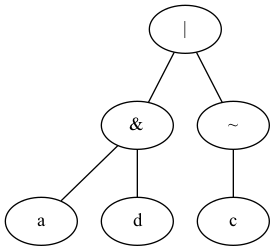

In [17]:
# show the above image here for convenience
from IPython.display import Image
Image(filename='data/bool_tree.png') 

GEP algorithm:
- create trainig set (for evaluate metric calculating)
- create primitives set (terminals and functions)
- create individual (set the schema of individual)
- crate population (set hyperparams)
- set the evaluate function
- set genetic operators
- set the statistics (for verbose logging)
- launch evolution

### 2. Dummy regular expression optimization

For test:

There are functions:
- alt (OR)
- group (AND)

There are terminals:
- a
- b
- c

Original regex:
```
a(b|c)(c|b)
```

Possible optimized regex:
```
abc|acb|acc|abb
```

#### 2.1 Synthetic dataset

In [18]:
TERMINALS = ['a', 'b', 'c']

def alt(*args):
    print(args)
    
def group(*args):
    print(args)

FUNCTIONS = {
    alt: 2,
    group: 3 + 1
}
TEST_STRINGS = [
    # target 1
    'abc',
    'acb',
    'acc',
    'abb',
    # target 0
    'aaa',
    'bbb',
    'ccc',
    'bca',
]

ORIGINAL_REGEX = 'a(b|c)(c|b)'

In [19]:
import re
import itertools

def f(string, regex):
    re_comp = re.compile(regex)
    try:
        return re_comp.match(string).group()
    except AttributeError:
        return None

def create_training_set(test_strings, original_regex):
    Y = []
    X = []
    for string in test_strings:
        X.append(string)
        Y.append(f(string=string, regex=original_regex))
    return X, Y

In [20]:
X, Y = create_training_set(
    test_strings=TEST_STRINGS,
    original_regex=ORIGINAL_REGEX
)

In [21]:
X

['abc', 'acb', 'acc', 'abb', 'aaa', 'bbb', 'ccc', 'bca']

In [22]:
Y

['abc', 'acb', 'acc', 'abb', None, None, None, None]

#### 2.2 Creating the primitives set

In [23]:
from typing import List, Dict

import geppy as gep
import operator

def create_primitives_set(
    terminals: List,
    # key - function
    # value - arity
    functions: Dict

):
    # terminals
    pset = gep.PrimitiveSet('Main', input_names=terminals)

    # functions
    for function in functions.keys():
        pset.add_function(function, functions.get(function))
    return pset

In [24]:
pset = create_primitives_set(
    terminals = TERMINALS,
    functions = FUNCTIONS
)

In [25]:
# terminals
pset._terminals

[<class 'geppy.core.symbol.SymbolTerminal'>(name=a, value=None),
 <class 'geppy.core.symbol.SymbolTerminal'>(name=b, value=None),
 <class 'geppy.core.symbol.SymbolTerminal'>(name=c, value=None)]

In [26]:
# functions
pset._functions

[<class 'geppy.core.symbol.Function'>(name=alt, arity=2),
 <class 'geppy.core.symbol.Function'>(name=group, arity=4)]

#### 2.3 Create the individual and population

In [27]:
from deap import creator, base, tools

def create_individual():
    creator.create("FitnessMin", base.Fitness, weights=(-1,))   # to minimize the objective (fitness)
    creator.create("Individual", gep.Chromosome, fitness=creator.FitnessMin)
    return creator

def create_popiulation(
    pset,
    head_length: int = 5,
    genes_number_in_chromosome: int = 2,
):

    h = head_length   # head length
    n_genes = genes_number_in_chromosome   # number of genes in a chromosome
    toolbox = gep.Toolbox()
    toolbox.register('gene_gen', gep.Gene, pset=pset, head_length=h)
    toolbox.register(
        'individual', 
        creator.Individual, 
        gene_gen=toolbox.gene_gen, 
        n_genes=n_genes,
        linker=group
    )
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # compile utility: which translates an individual into an executable function (Lambda)
    toolbox.register('compile', gep.compile_, pset=pset)
    return toolbox

In [28]:
# set individual

creator = create_individual()

/Users/nikitamoroskin/anaconda3/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [29]:
# set population
toolbox = create_popiulation(
    pset=pset, 
    head_length=5,
    genes_number_in_chromosome=4
)

In [30]:
toolbox.population

functools.partial(<function initRepeat at 0x10915b1c0>, <class 'list'>, functools.partial(<class 'deap.creator.Individual'>, gene_gen=functools.partial(<class 'geppy.core.entity.Gene'>, pset=<geppy.core.symbol.PrimitiveSet object at 0x109aa2950>, head_length=5), n_genes=4, linker=<function group at 0x109ae9090>))

In [31]:
toolbox.individual

functools.partial(<class 'deap.creator.Individual'>, gene_gen=functools.partial(<class 'geppy.core.entity.Gene'>, pset=<geppy.core.symbol.PrimitiveSet object at 0x109aa2950>, head_length=5), n_genes=4, linker=<function group at 0x109ae9090>)

#### 2.4 Define the fitness evaluationfunction

In [32]:
import time

N_ITER = 100

def get_match_accuracy(regex, phrase, result):
    try:
        reg_result = regex.match(phrase).group()
        if reg_result == result:
            return 1
        return 0
    except AttributeError:
        return 0
        
def get_performance_metric(regex, n_iter, test_strings):
    t0 = time.time() * 1000
    for _ in range(n_iter):
        for test_string in test_strings:
            _ = regex.match(test_string)
    return ((time.time() * 1000 - t0) / n_iter) / len(test_strings)


def dummy_lexical_analyzer(string):
    sep_symbols = ['(', ')', ',']
    tokens = []
    _current_token = ''
    for symbol in string:
        if symbol in sep_symbols:
            if _current_token != '':
                tokens.append(_current_token)
            tokens.append(symbol)
            _current_token = ''
        else:
            _current_token += symbol
    return tokens


def dummy_generator(tokens, current_state=None):
    result = []
    for i, token in enumerate(tokens):
        if token in TERMINALS:
            result.append(token)
        elif token == ',' and current_state == 'alt':
            result.append('|')
        elif token in ['(', ')'] and current_state in ['group', 'alt']:
            result.append(token)
        elif token == 'group':
            current_state = 'group'
        elif token == 'alt':
            current_state = 'alt'
    return result

def regex_compile(individual):
    individual = re.sub(r'\s', '', str(individual))
    tokens = dummy_lexical_analyzer(individual)
    regex = ''.join(dummy_generator(tokens))
    return re.compile(regex)

def evaluate(individual):
    global X, Y
    try:
        regex = regex_compile(individual)
    except:
        return 1
    
    # count accuracy metric
    accuracy = []
    for x, y in zip(X, Y):
        accuracy.append(
            get_match_accuracy(
                regex=regex, 
                phrase=x, 
                result=y
            )
        )
    coeff = (2. - sum(accuracy)/len(accuracy))

    # count performance metric
    res_metric = coeff * float(
        get_performance_metric(
            regex=regex,
            n_iter=N_ITER,
            test_strings=X
    ))
    
    return res_metric,

def set_evalute_function(
    toolbox,
    evaluate_function
):
    toolbox.register('evaluate', evaluate_function)
    return toolbox

In [33]:
toolbox = set_evalute_function(toolbox, evaluate_function=evaluate)

#### 2.5 Register genetic operators

In [34]:
def set_genetic_operators(
    toolbox,
    pset,
    head_length: int = 5
):
    toolbox.register('select', tools.selRoulette)
    ## general mutations whose aliases start with 'mut'
    # We can specify the probability for an operator with the .pbs property
    toolbox.register('mut_uniform', gep.mutate_uniform, pset=pset, ind_pb=2 / (2 * head_length + 1))
    toolbox.pbs['mut_uniform'] = 0.1
    # Alternatively, assign the probability along with registration using the pb keyword argument.
    toolbox.register('mut_invert', gep.invert, pb=0.1)
    toolbox.register('mut_is_ts', gep.is_transpose, pb=0.1)
    toolbox.register('mut_ris_ts', gep.ris_transpose, pb=0.1)
    toolbox.register('mut_gene_ts', gep.gene_transpose, pb=0.1)

    ## general crossover whose aliases start with 'cx'
    toolbox.register('cx_1p', gep.crossover_one_point, pb=0.1)
    toolbox.pbs['cx_1p'] = 0.4   # just show that the probability can be overwritten
    toolbox.register('cx_2p', gep.crossover_two_point, pb=0.2)
    toolbox.register('cx_gene', gep.crossover_gene, pb=0.1)
    return toolbox

In [35]:
toolbox = set_genetic_operators(toolbox, pset=pset)

#### 2.6 Statistics to be inspected

In [36]:
from typing import Dict

import numpy as np

def set_statistic(
    statistics_dict: Dict = {
        "avg": np.mean,
        "std": np.std,
        "min": np.min,
        "max": np.max
    }
):

    stats = tools.Statistics(key=lambda ind: ind.fitness.values[0])
    for statistic_name in statistics_dict.keys():
        stats.register(statistic_name, statistics_dict[statistic_name])
    return stats

In [37]:
stats = set_statistic()

#### 2.7 Launch evolution

In [38]:
import random

def launch_evolution(
    toolbox,
    stats,
    seed: int = 11,
):
    # this section is just for reproduction purpose since evolutionary algorithms all involve randomness
    random.seed(seed)
    
    # size of population and number of generations
    n_pop = 50
    n_gen = 50

    pop = toolbox.population(n=n_pop)
    hof = tools.HallOfFame(1)   # only record the best individual ever found in all generations

    # start evolution
    pop, log = gep.gep_simple(pop, toolbox,
                              n_generations=n_gen, n_elites=2,
                              stats=stats, hall_of_fame=hof, verbose=True)
    
    best = hof[0]
    print(best)
    return best

In [39]:
best = launch_evolution(
    toolbox=toolbox,
    stats=stats,
    seed=456,
)

gen	nevals	avg        	std        	min        	max        
0  	50    	0.000280688	0.000102603	0.000186768	0.000540771
1  	26    	0.000315186	0.000112178	0.000184937	0.000567627
2  	42    	0.000350854	0.000120628	0.000184937	0.000670166
3  	31    	0.000355585	0.000119177	0.000184937	0.000651855
4  	41    	0.000389014	0.000108131	0.000184937	0.000622559
5  	35    	0.00038042 	9.58407e-05	0.000184937	0.000541382
6  	41    	0.000374841	0.000106086	0.000184937	0.000681763
7  	35    	0.000390421	9.77162e-05	0.000184937	0.000627441
8  	34    	0.000379031	0.0001193  	0.000184937	0.000638008
9  	37    	0.00039436 	0.000120745	0.000184937	0.000647163
10 	38    	0.000396658	0.00012842 	0.000184937	0.000647163
11 	40    	0.000400723	0.000128785	0.000184937	0.000689697
12 	32    	0.000412585	0.000116084	0.000184937	0.000645142
13 	35    	0.000424892	0.000115543	0.000184937	0.000674438
14 	37    	0.000410446	0.000126443	0.000184937	0.000707397
15 	39    	0.000447064	0.000146014	0.000184937	0.0007598

#### 2.8 Post-processing: simplification and visualization

In [40]:
def see_individuals(best):
    print('- Content of the two genes: ')
    for gene in best:
        print(repr(gene))
    print('- K-expression of the two genes')
    for gene in best:
        print(gene.kexpression)

In [41]:
see_individuals(best=best)

- Content of the two genes: 
<class 'geppy.core.entity.Gene'> [group, a, a, a, c, c, a, c, b, b, a, c, a, a, a, c, c, c, c, a, b]
<class 'geppy.core.entity.Gene'> [group, alt, alt, group, group, a, a, a, a, a, b, a, a, c, c, a, c, c, a, b, b]
<class 'geppy.core.entity.Gene'> [alt, alt, group, alt, group, a, a, a, a, a, b, a, a, c, c, a, c, c, a, b, b]
<class 'geppy.core.entity.Gene'> [alt, alt, alt, alt, group, a, a, b, b, a, b, b, c, c, a, a, b, c, b, a, b]
- K-expression of the two genes
[group, a, a, a, c]
[group, alt, alt, group, group, a, a, a, a, a, b, a, a, c, c, a, c]
[alt, alt, group, alt, group, a, a, a, a, a, b, a, a, c, c]
[alt, alt, alt, alt, group, a, a, b, b, a, b, b, c]


In [42]:
evaluate(best)

(0.0001904296875,)

In [43]:
rename_labels = {'group': 'group', 'alt': 'alt'}
gep.export_expression_tree(best, rename_labels, 'data/dummy_regexp_tree.png')

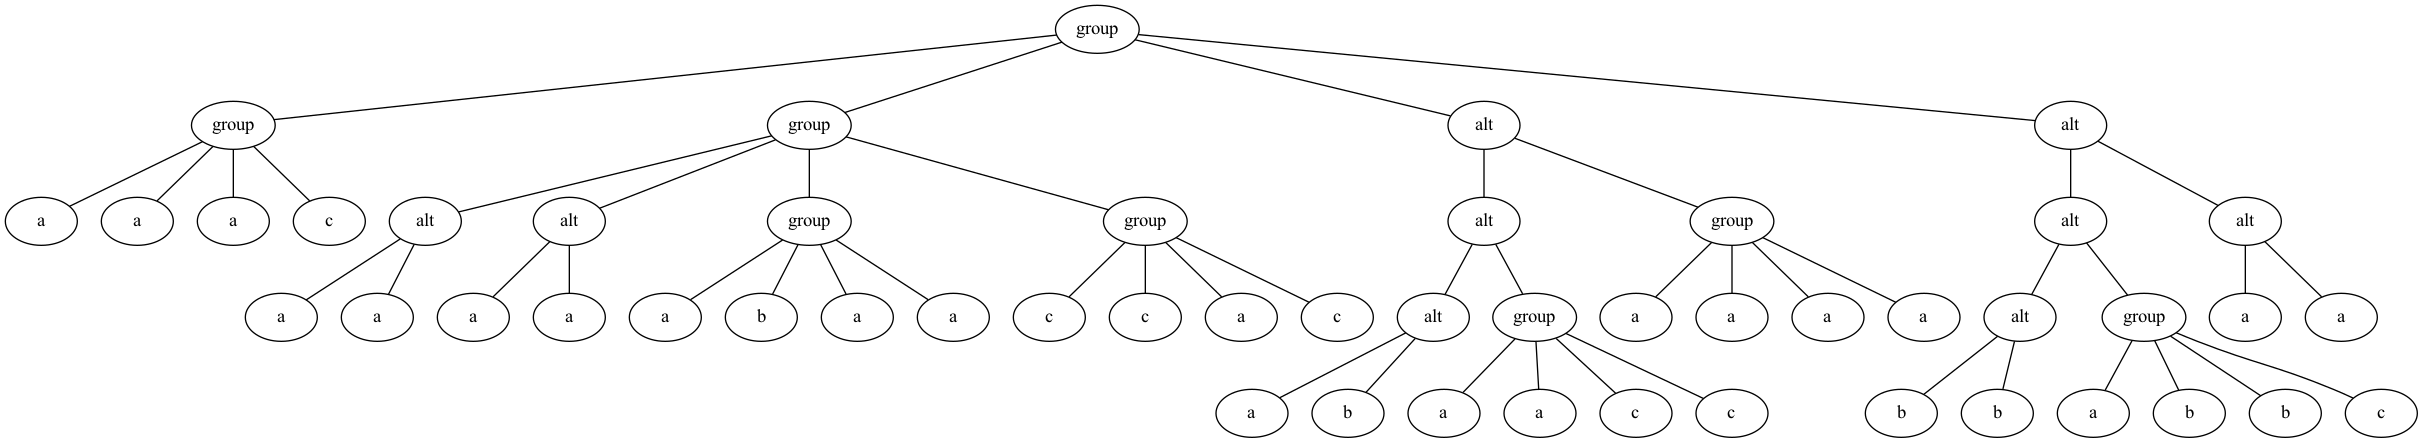

In [44]:
from IPython.display import Image
Image(filename='data/dummy_regexp_tree.png') 

### 3. Regular expression optimization

There are functions:
- alt
- group
- escape
- repeat (only for params from memory)
- range (only for params from memory)

There are terminals:
- all unicode letters
- any

Original regex:
```
ab?c.|[0-9]\[
```

#### 3.1  Synthetic dataset

Prepare terminals (all unicode letters)

In [45]:
import unicodedata
from geppy.core.symbol import _is_nonkeyword_identifier

def get_all_unicode_letters(start_code, stop_code):
    start_idx, stop_idx = [int(code, 16) for code in (start_code, stop_code)]
    characters = []
    for unicode_idx in range(start_idx, stop_idx + 1):
        characters.append(chr(unicode_idx))
    return characters

TERMINALS = []

# Latin upper
TERMINALS += get_all_unicode_letters('0041', '005A')

# Latin lower
TERMINALS += get_all_unicode_letters('0061', '007A')

# digits
TERMINALS += get_all_unicode_letters('0030', '0039')

# check ability to get __name__
correct_terminals = []

for x in TERMINALS:
    try:
        assert _is_nonkeyword_identifier(x)
        correct_terminals.append(x)
    except Exception as e:
        pass
    
TERMINALS = correct_terminals

# range group and escape in this work will be terminals
TERMINALS += ['range', 'any', 'escape']

Prepare functions

In [46]:
def alt(*args):
    return args
    
def group(*args):
    return args

def repeat(*args):
    return args

FUNCTIONS = {
    alt: 2,
    group: 10,
    repeat: 1,
}

Prepare test strings and define original regex

In [47]:
import exrex

ORIGINAL_REGEX = 'ab?c.|[0-9]\['

PARAMS = {
    'range': ['0-9'],
    'repeat': ['0,1']
}

N_FUZZY_STRINGS = 5

TEST_STRINGS = list(exrex.generate(ORIGINAL_REGEX, limit=N_FUZZY_STRINGS))

Create synthetic dataset

In [48]:
import re
import itertools

def f(string, regex):
    re_comp = re.compile(regex)
    try:
        return re_comp.match(string).group()
    except AttributeError:
        return None

def create_training_set(test_strings, original_regex):
    Y = []
    X = []
    for string in test_strings:
        X.append(string)
        Y.append(f(string=string, regex=original_regex))
    return X, Y

In [49]:
X, Y = create_training_set(
    test_strings=TEST_STRINGS,
    original_regex=ORIGINAL_REGEX
)

In [50]:
len(X), len(Y)

(192, 192)

#### 3.2 Creating the primitives set

In [51]:
from typing import List, Dict

import geppy as gep
import operator

def create_primitives_set(
    terminals: List,
    # key - function
    # value - arity
    functions: Dict

):
    # terminals
    pset = gep.PrimitiveSet('Main', input_names=terminals)

    # functions
    for function in functions.keys():
        pset.add_function(function, functions.get(function))
    return pset

In [52]:
pset = create_primitives_set(
    terminals = TERMINALS,
    functions = FUNCTIONS
)

#### 3.3 Create the individual and population

In [53]:
from deap import creator, base, tools

def create_individual():
    creator.create("FitnessMin", base.Fitness, weights=(-1,))   # to minimize the objective (fitness)
    creator.create("Individual", gep.Chromosome, fitness=creator.FitnessMin)
    return creator

def create_popiulation(
    pset,
    head_length: int = 5,
    genes_number_in_chromosome: int = 2,
):

    h = head_length   # head length
    n_genes = genes_number_in_chromosome   # number of genes in a chromosome
    toolbox = gep.Toolbox()
    toolbox.register('gene_gen', gep.Gene, pset=pset, head_length=h)
    toolbox.register(
        'individual', 
        creator.Individual, 
        gene_gen=toolbox.gene_gen, 
        n_genes=n_genes,
        linker=group
    )
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # compile utility: which translates an individual into an executable function (Lambda)
    toolbox.register('compile', gep.compile_, pset=pset)
    return toolbox

In [54]:
# set individual

creator = create_individual()

/Users/nikitamoroskin/anaconda3/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/nikitamoroskin/anaconda3/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [55]:
# set population
toolbox = create_popiulation(
    pset=pset, 
    head_length=5,
    genes_number_in_chromosome=2
)

#### 3.4 Define the fitness evaluation function

In [56]:
import time
import random

N_ITER = 100

def get_match_accuracy(regex, phrase, result):
    try:
        reg_result = regex.match(phrase).group()
        if reg_result == result:
            return 1
        return 0
    except AttributeError:
        return 0
        
def get_performance_metric(regex, n_iter, test_strings):
    t0 = time.time() * 1000
    for _ in range(n_iter):
        for test_string in test_strings:
            _ = regex.match(test_string)
    return ((time.time() * 1000 - t0) / n_iter) / len(test_strings)


def lexical_analyzer(string):
    sep_symbols = ['(', ')', ',']
    tokens = []
    _current_token = ''
    for symbol in string:
        if symbol in sep_symbols:
            if _current_token != '':
                tokens.append(_current_token)
            tokens.append(symbol)
            _current_token = ''
        else:
            _current_token += symbol
    return tokens


def generator(tokens, current_state=None):
    result = []
    repeat = False
    for i, token in enumerate(tokens):
        if token in TERMINALS:
            # work with special terminals
            if token == 'escape':
                result.append('\\')
            elif token == 'any':
                result.append('.')
            elif token == 'range':
                result.append(f'[{random.choice(PARAMS["range"])}]')
            else:
                result.append(token)
        # add arguments
        elif token == ',' and current_state == 'alt':
            result.append('|')
        elif token == ')' and repeat is True and current_state is None:
            result.append(f'{"{"}{random.choice(PARAMS["repeat"])}{"}"}')
            repeat = False
        elif token == '(' and current_state in ['group', 'alt']:
            result.append(token)
        elif token == ')':
            current_state = None
            result.append(')')
        # check functions
        elif token == 'group':
            current_state = 'group'
        elif token == 'repeat':
            repeat = True
        elif token == 'alt':
            current_state = 'alt'
    return result

def regex_compile(individual):
    individual = re.sub(r'\s', '', str(individual))
    tokens = lexical_analyzer(individual)
    regex = ''.join(generator(tokens)) + ')'
    try:
        return re.compile(regex), None
    except Exception as e:
        return None, f'error: {e}, string: {regex}'

def evaluate(individual):
    global X, Y
    regex = regex_compile(individual)[0]
    
    if not regex:
        return 1_000,
    
    # count accuracy metric
    accuracy = []
    for x, y in zip(X, Y):
        accuracy.append(
            get_match_accuracy(
                regex=regex, 
                phrase=x, 
                result=y
            )
        )
    accuracy = sum(accuracy)/len(accuracy)

    try:
        res_metric = float(
            get_performance_metric(
                regex=regex,
                n_iter=N_ITER,
                test_strings=X
        )) / accuracy
    except ZeroDivisionError:
        res_metric = 1_000

    return res_metric,

def set_evalute_function(
    toolbox,
    evaluate_function
):
    toolbox.register('evaluate', evaluate_function)
    return toolbox

In [57]:
toolbox = set_evalute_function(toolbox, evaluate_function=evaluate)

#### 3.5 Register genetic operators

In [58]:
def set_genetic_operators(
    toolbox,
    pset,
    head_length: int = 5
):
    toolbox.register('select', tools.selRoulette)
    ## general mutations whose aliases start with 'mut'
    # We can specify the probability for an operator with the .pbs property
    toolbox.register('mut_uniform', gep.mutate_uniform, pset=pset, ind_pb=2 / (2 * head_length + 1))
    toolbox.pbs['mut_uniform'] = 0.3
    # Alternatively, assign the probability along with registration using the pb keyword argument.
    toolbox.register('mut_invert', gep.invert, pb=0.1)
    toolbox.register('mut_is_ts', gep.is_transpose, pb=0.1)
    toolbox.register('mut_ris_ts', gep.ris_transpose, pb=0.1)
    toolbox.register('mut_gene_ts', gep.gene_transpose, pb=0.4)

    ## general crossover whose aliases start with 'cx'
    toolbox.register('cx_1p', gep.crossover_one_point, pb=0.1)
    toolbox.pbs['cx_1p'] = 0.4   # just show that the probability can be overwritten
    toolbox.register('cx_2p', gep.crossover_two_point, pb=0.2)
    toolbox.register('cx_gene', gep.crossover_gene, pb=0.1)
    return toolbox

In [59]:
toolbox = set_genetic_operators(toolbox, pset=pset)

#### 3.6 Statistics to be inspected

In [60]:
from typing import Dict

import numpy as np

def set_statistic(
    statistics_dict: Dict = {
        "avg": np.mean,
        "std": np.std,
        "min": np.min,
        "max": np.max
    }
):

    stats = tools.Statistics(key=lambda ind: ind.fitness.values[0])
    for statistic_name in statistics_dict.keys():
        stats.register(statistic_name, statistics_dict[statistic_name])
    return stats

In [61]:
stats = set_statistic()

#### 3.7 Launch evolution

In [62]:
import random

def launch_evolution(
    toolbox,
    stats,
    seed: int = 11,
):
    # this section is just for reproduction purpose since evolutionary algorithms all involve randomness
    random.seed(seed)
    
    # size of population and number of generations
    n_pop = 500
    n_gen = 100

    pop = toolbox.population(n=n_pop)
    hof = tools.HallOfFame(1)   # only record the best individual ever found in all generations

    # start evolution
    pop, log = gep.gep_simple(pop, toolbox,
                              n_generations=n_gen, n_elites=2,
                              stats=stats, hall_of_fame=hof, verbose=True)
    
    best = hof[0]
    print(best)
    return best

In [63]:
best = launch_evolution(
    toolbox=toolbox,
    stats=stats,
    seed=156,
)

gen	nevals	avg	std    	min      	max 
0  	500   	996	63.1187	0.0030542	1000
1  	438   	996	63.1187	0.0030542	1000
2  	435   	996	63.1187	0.0030542	1000
3  	436   	996	63.1187	0.0030542	1000
4  	427   	996	63.1187	0.0030542	1000
5  	424   	996	63.1187	0.0030542	1000
6  	448   	994	77.2267	0.0026582	1000
7  	432   	996	63.1188	0.0026582	1000
8  	426   	996	63.1188	0.0026582	1000
9  	435   	996	63.1188	0.0026582	1000
10 	433   	996	63.1188	0.0026582	1000
11 	429   	994	77.2267	0.00265186	1000
12 	439   	996	63.1188	0.00265186	1000
13 	434   	996	63.1188	0.00265186	1000
14 	450   	996	63.1188	0.00265186	1000
15 	444   	996	63.1188	0.00265186	1000
16 	437   	996	63.1188	0.00265186	1000
17 	438   	996	63.1188	0.00265186	1000
18 	433   	996	63.1188	0.00265186	1000
19 	434   	992	89.084 	0.0021499 	1000
20 	431   	996	63.1188	0.0021499 	1000
21 	436   	996	63.1188	0.0021499 	1000
22 	425   	992	89.084 	0.00214819	1000
23 	419   	996	63.1188	0.00214819	1000
24 	422   	996	63.1188	0.00214819	100

#### 3.8 Post-processing: simplification and visualization

In [64]:
def see_individuals(best):
    print('- Content of the two genes: ')
    for gene in best:
        print(repr(gene))
    print('- K-expression of the two genes')
    for gene in best:
        print(gene.kexpression)

In [65]:
see_individuals(best=best)

- Content of the two genes: 
<class 'geppy.core.entity.Gene'> [range, r, repeat, F, C, g, I, V, q, P, N, any, N, l, U, M, range, H, b, o, w, I, O, u, X, k, l, z, Q, i, m, q, X, z, O, M, i, L, e, c, v, X, z, X, D, escape, c, N, L, S, X]
<class 'geppy.core.entity.Gene'> [repeat, repeat, any, i, group, D, r, e, v, d, A, K, range, o, b, range, y, M, K, Q, u, Y, D, R, g, S, F, g, range, P, b, j, l, G, m, f, w, n, q, y, any, X, Q, Y, X, q, S, K, q, B, w]
- K-expression of the two genes
[range]
[repeat, repeat, any]


In [66]:
evaluate(best)

(0.0020712890625,)

In [67]:
rename_labels = {'group': 'group', 'alt': 'alt', 'repeat': 'repeat', 'escape': 'escape', '_range': 'range'}
gep.export_expression_tree(best, rename_labels, 'data/regexp_tree.png')

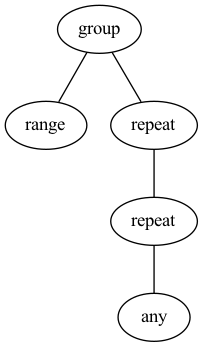

In [68]:
from IPython.display import Image
Image(filename='data/regexp_tree.png')

In [69]:
regex_compile(best)

(re.compile(r'([0-9]((.){0,1}))', re.UNICODE), None)